In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
import scipy
import time

from models.sub_cos_glm import Sub_Cos_GLM
from models.sub_tcn import Sub_TCN
from models.gru import GRU

# Hyperparameters

In [2]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"
E_neural_file = "Espikes_neural.npz"
I_neural_file = "Ispikes_neural.npz"
#V_file = "vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_noDendNa_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"
V_file = "V_diff.npy"
eloc_file = "Elocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"
iloc_file = "Ilocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"

E_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
#V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)[:,:50000].flatten()
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)
V = torch.from_numpy(V)
#V -= torch.mean(V)
eloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+eloc_file)
iloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+iloc_file)

den_idx = np.unique(eloc[880:1120,0])
e_idx = np.where(np.isin(eloc[:,0], den_idx) == True)[0]
i_idx = np.where(np.isin(iloc[:,0], den_idx) == True)[0]
e_idx = torch.from_numpy(e_idx)
i_idx = torch.from_numpy(i_idx)

part_C_syn_e = np.load("/media/hdd01/sklee/CA1_clust4-60/data/handsub6_C_syn_e.npy")
part_C_syn_i = np.load("/media/hdd01/sklee/CA1_clust4-60/data/handsub6_C_syn_i.npy")
part_C_syn_e = torch.from_numpy(part_C_syn_e)
part_C_syn_i = torch.from_numpy(part_C_syn_i)

#C_syn_e = np.load("/media/hdd01/sklee/CA1_clust4-60/glm_diff_s7_h2_C_syn_e.npy")
#C_syn_i = np.load("/media/hdd01/sklee/CA1_clust4-60/glm_diff_s7_h2_C_syn_i.npy")
#C_syn_e = torch.from_numpy(C_syn_e)
#C_syn_i = torch.from_numpy(C_syn_i)

In [4]:
T_train = 980 * 1000 * 50
T_test = 1 * 1000 * 50
H_no = 2
sub_no = 10
two_nonlin = False
E_no = 2000
I_no = 200
T_no = 500
device = torch.device("cuda")

increment = 50
batch_length = 50000
batch_size = 5
iter_no = 9800*2
epoch_no = iter_no*batch_length*batch_size//T_train 

# Preprocess

In [5]:
V_train = V[:T_train].float()
V_test = V[-50000:].to(device).float()

test_E_neural = E_neural[-50000:].toarray()
test_I_neural = I_neural[-50000:].toarray()
train_E_neural = E_neural[:T_train]
train_I_neural = I_neural[:T_train]

test_E_neural = torch.from_numpy(test_E_neural).float().to(device)
test_I_neural = torch.from_numpy(test_I_neural).float().to(device)

train_idx = np.empty((epoch_no, T_train//batch_length//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0, T_train, batch_length*batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

In [6]:

C_syn_e = torch.zeros(sub_no, E_no).to(device)
C_syn_i = torch.zeros(sub_no, I_no).to(device)

for i in range(E_no):
    idx = np.random.randint(0,sub_no)
    C_syn_e[idx,i] = 1
    
for i in range(I_no):
    idx = np.random.randint(0,sub_no)
    C_syn_i[idx,i] = 1


In [7]:
"""
C_syn_e = torch.zeros(sub_no, E_no).to(device)
C_syn_e[:6] = part_C_syn_e

C_syn_i = torch.zeros(sub_no, I_no).to(device)
C_syn_i[:6] = part_C_syn_i

for i in range(E_no):
    den = eloc[i,0]
    if den == den_idx[0]:
        C_syn_e[:,i] = 0
        C_syn_e[-4,i] = 1
    elif den == den_idx[1]:
        C_syn_e[:,i] = 0
        C_syn_e[-3,i] = 1
    elif den == den_idx[2]:
        C_syn_e[:,i] = 0
        C_syn_e[-2,i] = 1
    elif den == den_idx[3]:
        C_syn_e[:,i] = 0
        C_syn_e[-1,i] = 1

for i in range(I_no):
    den = iloc[i,0]
    if den == den_idx[0]:
        C_syn_i[:,i] = 0
        C_syn_i[-4,i] = 1
    elif den == den_idx[1]:
        C_syn_i[:,i] = 0
        C_syn_i[-3,i] = 1
    elif den == den_idx[2]:
        C_syn_i[:,i] = 0
        C_syn_i[-2,i] = 1
    elif den == den_idx[3]:
        C_syn_i[:,i] = 0
        C_syn_i[-1,i] = 1
"""

'\nC_syn_e = torch.zeros(sub_no, E_no).to(device)\nC_syn_e[:6] = part_C_syn_e\n\nC_syn_i = torch.zeros(sub_no, I_no).to(device)\nC_syn_i[:6] = part_C_syn_i\n\nfor i in range(E_no):\n    den = eloc[i,0]\n    if den == den_idx[0]:\n        C_syn_e[:,i] = 0\n        C_syn_e[-4,i] = 1\n    elif den == den_idx[1]:\n        C_syn_e[:,i] = 0\n        C_syn_e[-3,i] = 1\n    elif den == den_idx[2]:\n        C_syn_e[:,i] = 0\n        C_syn_e[-2,i] = 1\n    elif den == den_idx[3]:\n        C_syn_e[:,i] = 0\n        C_syn_e[-1,i] = 1\n\nfor i in range(I_no):\n    den = iloc[i,0]\n    if den == den_idx[0]:\n        C_syn_i[:,i] = 0\n        C_syn_i[-4,i] = 1\n    elif den == den_idx[1]:\n        C_syn_i[:,i] = 0\n        C_syn_i[-3,i] = 1\n    elif den == den_idx[2]:\n        C_syn_i[:,i] = 0\n        C_syn_i[-2,i] = 1\n    elif den == den_idx[3]:\n        C_syn_i[:,i] = 0\n        C_syn_i[-1,i] = 1\n'

# Train

In [8]:
#model = Sub_Cos_GLM(C_syn_e.to(device), C_syn_i.to(device), T_no, H_no, two_nonlin, device)
#model = GRU(C_syn_e.to(device), C_syn_i.to(device), H_no, device)
model = Sub_TCN(C_syn_e.to(device), C_syn_i.to(device), T_no, H_no, two_nonlin, device)

# GLM (1.025 for V_diff, 1 for noNA)
#optimizer = torch.optim.Adam(model.parameters(), lr = 0.005/(1.025**100))
#milestones = np.arange(increment-1, increment*100, increment)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=1.025)

# TCN (1. for V_diff, 1 for noNA)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005/(1**100))
milestones = np.arange(increment-1, increment*100, increment)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=1)

# GRU (1 for V_diff, 1 for noNA)
#optimizer = torch.optim.Adam(model.parameters(), lr = 0.0025/(1**100))
#milestones = np.arange(increment-1, increment*100, increment)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=1)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

22241


In [9]:
score_list = []

for i in tnrange(iter_no):
    s = time.time()
    model.train()
    optimizer.zero_grad()
    
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_E_neural = torch.from_numpy(batch_E_neural).float().to(device)
    batch_I_neural = torch.from_numpy(batch_I_neural).float().to(device)
    batch_V = V_train[batch_idx : batch_idx+batch_length*batch_size].reshape(batch_size, -1).to(device)
    
    V_pred, _ = model(batch_E_neural, batch_I_neural)
    s = time.time()
    
    loss = torch.mean((V_pred - batch_V)**2)
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        test_V_pred, test_sub_out = model(test_E_neural.unsqueeze(0), test_I_neural.unsqueeze(0))
        test_V_pred = test_V_pred.flatten()
                 
        test_score = explained_variance_score(V_test.cpu().detach().numpy(), test_V_pred.cpu().detach().numpy())
        test_mse = torch.mean((V_test-test_V_pred)**2).item()
        score_list.append(test_score)
                
        print(i, np.round(test_score,6),
              np.round(test_mse,6))


<ipython-input-9-c0ec9da4b676>:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


0 -0.573508 0.841758
49 -0.042745 0.03027
99 0.048607 0.026128
149 0.112955 0.024385
199 0.152762 0.02328
249 0.175597 0.02264
299 0.188455 0.022279
349 0.195904 0.022128
399 0.201483 0.021939
449 0.207484 0.021762
499 0.208674 0.021791
549 0.209404 0.021743
599 0.213562 0.021696
649 0.215015 0.021698
699 0.220487 0.021629
749 0.219331 0.021636
799 0.22842 0.021186
849 0.222897 0.021414
899 0.223109 0.02138
949 0.222037 0.021357
999 0.22425 0.021453
1049 0.221922 0.021556
1099 0.22461 0.021303
1149 0.219216 0.021458
1199 0.22374 0.021439
1249 0.226272 0.021366
1299 0.220501 0.022095
1349 0.229655 0.022034
1399 0.220852 0.021783
1449 0.217227 0.021858
1499 0.229169 0.021201
1549 0.222851 0.02153
1599 0.221048 0.021486
1649 0.227014 0.021283
1699 0.224055 0.021302
1749 0.222813 0.021815
1799 0.219743 0.021421
1849 0.215619 0.021678
1899 0.225936 0.021273
1949 0.217745 0.021476
1999 0.215346 0.021563
2049 0.218526 0.021456



KeyboardInterrupt: 

In [ ]:
plt.plot(np.asarray(score_list))

In [9]:
kern_basis = torch.zeros(24, T_no).to(device)
for i in range(24):
    phi = 1.5707963267948966*i
    xmin = phi - 3.141592653589793
    xmax = phi + 3.141592653589793

    x_in = torch.arange(0, T_no, 1)
    raw_cos = 6  * torch.log(x_in + 1 + 1e-7)

    basis = 0.5*torch.cos(raw_cos - phi) + 0.5
    basis[raw_cos < xmin] = 0.0
    basis[raw_cos > xmax] = 0.0
    kern_basis[i] = basis
    
kern_e = torch.matmul(model.W_e_layer1, kern_basis)
kern_i = torch.matmul(model.W_i_layer1, kern_basis)
kern_e = kern_e.cpu().detach().numpy()
kern_i = kern_i.cpu().detach().numpy()

scale_e = model.E_scale.cpu().detach().numpy()
scale_i = model.I_scale.cpu().detach().numpy()

print(kern_e.shape)
print(kern_i.shape)
print(scale_e.shape)
print(scale_i.shape)

(10, 500)
(10, 500)
(2000,)
(200,)


In [10]:
#torch.save(model.state_dict(), "/media/hdd01/sklee/CA1_clust4-60/random/tcn_s10_h2.pt")

#np.save("/media/hdd01/sklee/CA1_clust4-60/hand/gru_s10_h7_output.npy", test_V_pred.cpu().detach().numpy().flatten())

#np.savez("/media/hdd01/sklee/CA1_clust4-60/hand/gru_s10_h7_output.npz",
         #test = test_V_pred.cpu().detach().numpy().flatten(),
         #kern_e = kern_e,
         #kern_i = kern_i,
         #scale_e = scale_e,
         #scale_i = scale_i)

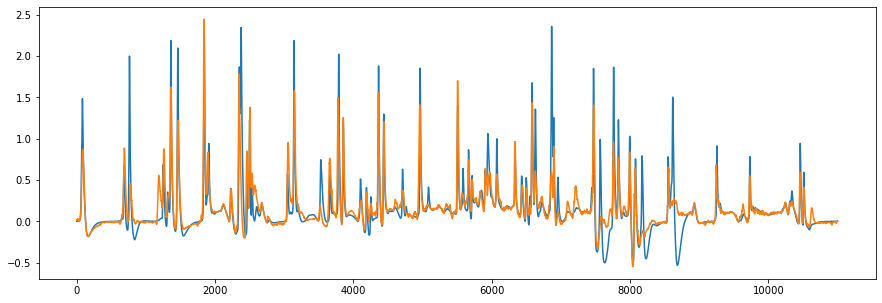

In [11]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[17000:28000])
plt.plot(test_V_pred.cpu().detach().numpy()[17000:28000])

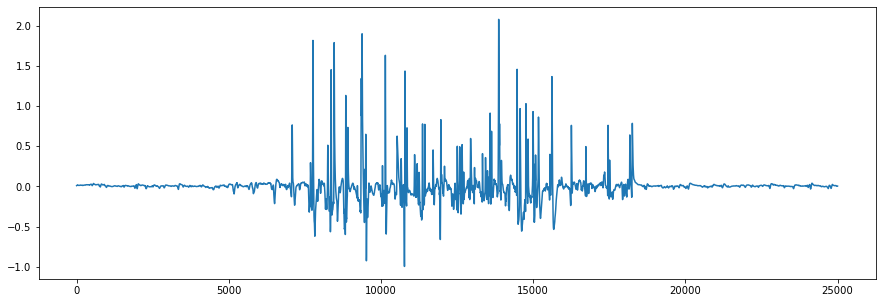

In [9]:
resid = V_test - test_V_pred

plt.figure(figsize = (15,5))
plt.plot(resid.cpu().detach().numpy()[10000:35000])

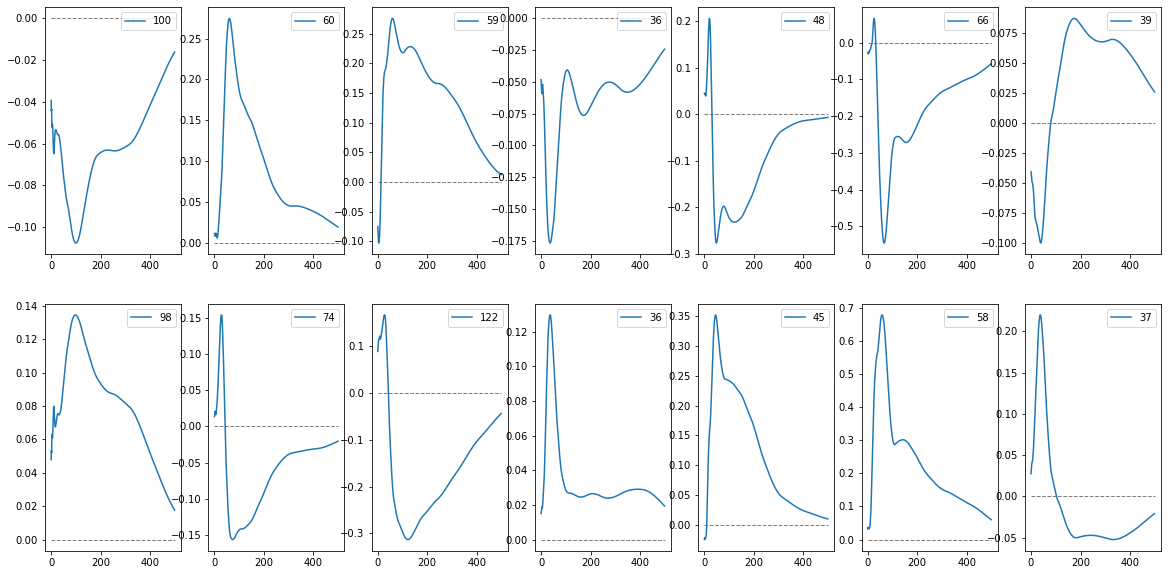

In [14]:
fig, axs = plt.subplots(nrows = H_no, ncols= sub_no, figsize = (20,10))

for i in range(H_no):
    for j in range(sub_no):
        idx = j*H_no + i
        max_t = np.argmax(np.abs(kern_e[idx]))
        axs[i,j].plot(kern_e[idx], label=str(max_t))
        axs[i,j].hlines(y=0, xmin=0, xmax=T_no, linewidth=1, linestyle="--", color="gray")
        axs[i,j].legend()

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

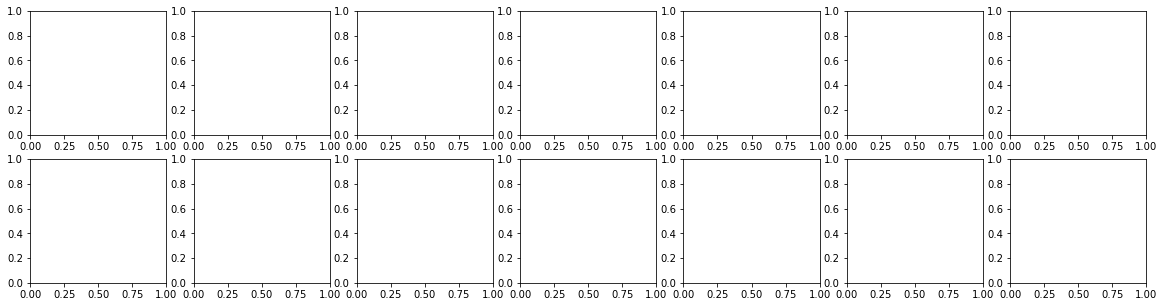

In [15]:
fig, axs = plt.subplots(nrows = H_no, ncols= sub_no, figsize = (20,5))

for i in range(H_no):
    for j in range(sub_no):
        idx = j*H_no + i
        max_t = np.argmax(np.abs(kern_e[idx]))
        axs[j].plot(kern_e[idx], label=str(max_t))
        axs[j].hlines(y=0, xmin=0, xmax=T_no, linewidth=1, linestyle="--", color="gray")
        axs[j].legend()

In [ ]:
plt.plot(np.exp(model.E_scale.cpu().detach().numpy()))

In [6]:
model = Sub_Cos_GLM(C_syn_e, C_syn_i, T_no, H_no, two_nonlin, device)
model.load_state_dict(torch.load("/media/hdd01/sklee/CA1_clust4-60/glm_diff_s10_h2.pt"))
model.eval()
model.cuda()

Sub_Cos_GLM()

In [7]:
test_V_pred, test_sub_out = model(test_E_neural.unsqueeze(0), test_I_neural.unsqueeze(0))
test_V_pred = test_V_pred.flatten()

IndexError: index 7 is out of bounds for dimension 2 with size 7

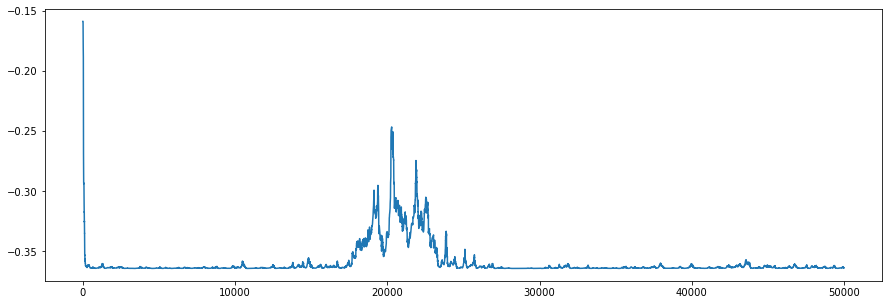

In [13]:
plt.figure(figsize = (15,5))
plt.plot(test_sub_out[0,:,6].cpu().detach().numpy(), label="1")
plt.plot(test_sub_out[0,:,7].cpu().detach().numpy(), label="1")
plt.plot(test_sub_out[0,:,8].cpu().detach().numpy(), label="1")
plt.plot(test_sub_out[0,:,9].cpu().detach().numpy(), label="1")
plt.legend()
plt.xlim(16000,29000)

In [15]:
C_syn_plot = np.zeros((E_no))

for e in range(E_no):
    C_syn_plot[e] = torch.argmax(C_syn_e[:,e])

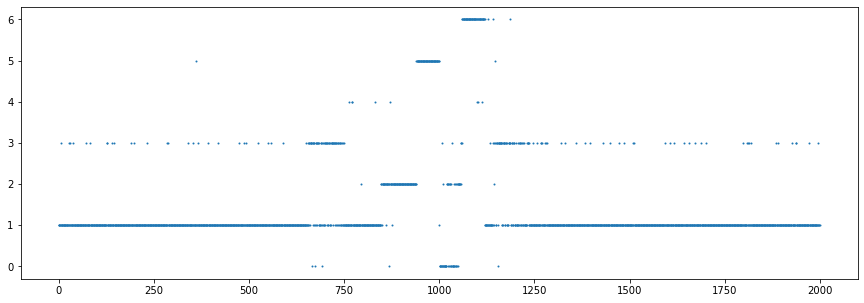

In [16]:
plt.figure(figsize = (15,5))
plt.scatter(np.arange(E_no), C_syn_plot, s=1)

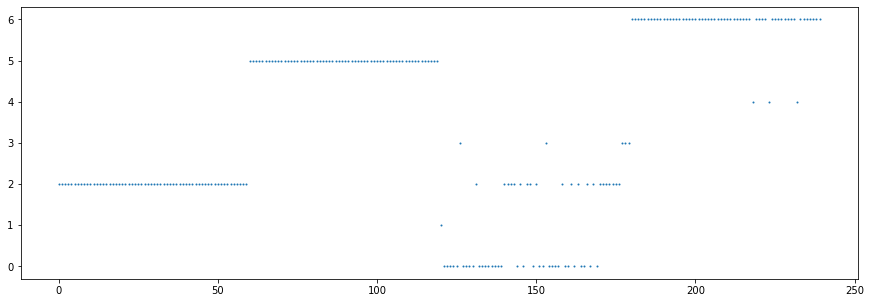

In [17]:
plt.figure(figsize = (15,5))
plt.scatter(np.arange(240), C_syn_plot[880:1120], s=1)

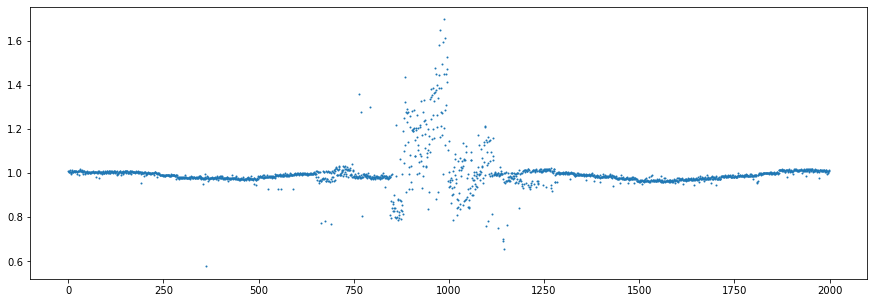

In [18]:
plt.figure(figsize = (15,5))
plt.scatter(np.arange(E_no), np.exp(model.E_scale.cpu().detach().numpy()), s=1)

In [18]:
print(torch.exp(model.W_layer2))

tensor([[0.2894, 0.2605],
        [0.4142, 0.3161],
        [0.2009, 0.2507],
        [0.1405, 0.3534],
        [0.2573, 0.2309],
        [0.2935, 0.3993],
        [0.2392, 0.1252]], device='cuda:0', grad_fn=<ExpBackward>)
